<a href="https://colab.research.google.com/github/JSJeong-me/CNN-Cats-Dogs/blob/main/3_aug_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%matplotlib inline

In [4]:
!ls -l

total 8
drwx------ 5 root root 4096 Jan 22 05:45 drive
drwxr-xr-x 1 root root 4096 Jan 20 17:27 sample_data


In [5]:
!cp ./drive/MyDrive/training_data.zip .

In [ ]:
!unzip training_data.zip

In [9]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [10]:
IMG_DIM = (150, 150)

train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[1].split('.')[0].strip() for fn in train_files]

validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[1].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (1000, 150, 150, 3)


In [11]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

(150, 150, 3)


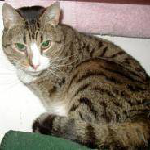

In [12]:
print(train_imgs[99].shape)
array_to_img(train_imgs[99])

In [13]:
batch_size = 50
num_classes = 2
epochs = 150
input_shape = (150, 150, 3)

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[1495:1505], train_labels_enc[1495:1505])

['dog', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'cat'] [1 0 0 0 0 1 1 0 1 0]


In [14]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=30,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

In [15]:
val_datagen = ImageDataGenerator(rescale=1./255)

Labels: ['cat', 'cat', 'cat', 'cat', 'cat']


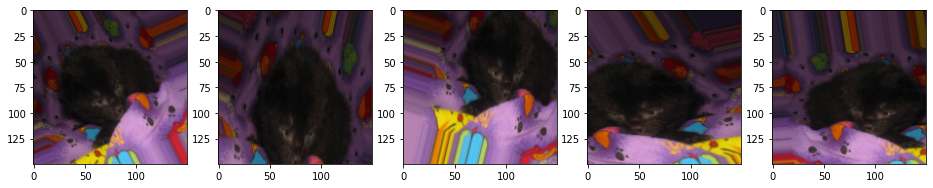

In [16]:
img_id = 1000
cat_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
cat = [next(cat_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in cat])
l = [ax[i].imshow(cat[i][0][0]) for i in range(0,5)]

Labels: ['cat', 'cat', 'cat', 'cat', 'cat']


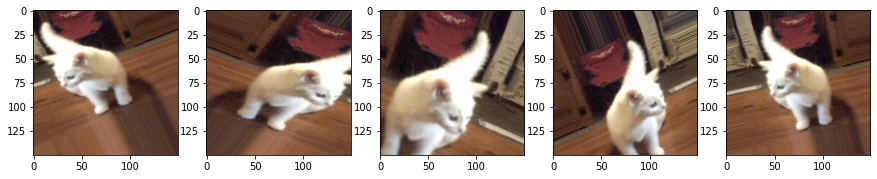

In [17]:
img_id = 1991
dog_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
dog = [next(dog_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(15, 6))
print('Labels:', [item[1][0] for item in dog])
l = [ax[i].imshow(dog[i][0][0]) for i in range(0,5)]

In [18]:
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=32)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=16)

input_shape = (150, 150, 3)

In [19]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

### Model Case I 

In [20]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', padding="same",
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate = 0.3))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate = 0.2))
model.add(BatchNormalization())

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate = 0.15))
model.add(BatchNormalization())

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate = 0.1))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [21]:
model.compile(loss='binary_crossentropy',
              optimizer= 'ADAM', # optimizers.RMSprop(lr=0.0001)
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 37, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 37, 37, 64)        2

In [ ]:
history = model.fit_generator(train_generator,  epochs=epochs,
                              validation_data=val_generator,  verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
94/94 [==============================] - 23s 161ms/step - loss: 2.7941 - accuracy: 0.4865 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 2/150
94/94 [==============================] - 15s 157ms/step - loss: 0.7024 - accuracy: 0.5276 - val_loss: 0.6863 - val_accuracy: 0.5010
Epoch 3/150
94/94 [==============================] - 15s 158ms/step - loss: 0.6740 - accuracy: 0.5838 - val_loss: 0.6863 - val_accuracy: 0.5000
Epoch 4/150
94/94 [==============================] - 15s 157ms/step - loss: 0.6720 - accuracy: 0.5749 - val_loss: 0.6924 - val_accuracy: 0.5210
Epoch 5/150
94/94 [==============================] - 15s 155ms/step - loss: 0.6950 - accuracy: 0.5016 - val_loss: 0.6919 - val_accuracy: 0.5130
Epoch 6/150
94/94 [==============================] - 15s 154ms/step - loss: 0.6866 - accuracy: 0.5270 - val_loss: 0.6936 - val_accuracy: 0.5010
Epoch 7/150
94/94 [==============================] - 15s 155ms/step - loss: 0.6718 - accuracy: 0.5646 - val_loss: 0.6905 - val_accuracy:

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,151))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 151, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 151, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
model.save('3-aug-cnn.h5')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
